# Importing Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.preprocessing import LabelEncoder

In [7]:
df = pd.read_csv('/kaggle/input/bengali-sms-dataset/bangla_smish.csv')
df

,label,text
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...
1,normal,আপনার দিন কেমন কাটছে?
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও..."
3,normal,"হ্যালো, কি খবর?"
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...
...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ..."
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!
2285,normal,আপনার কেমন দিন কাটছে?


# Data Cleaning

In [8]:
df.head()

,label,text
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...
1,normal,আপনার দিন কেমন কাটছে?
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও..."
3,normal,"হ্যালো, কি খবর?"
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...


In [9]:
df.shape

(2287, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287 entries, 0 to 2286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2287 non-null   object
 1   text    2287 non-null   object
dtypes: object(2)
memory usage: 35.9+ KB


In [11]:
def punctuation_removal(text): 
    text = re.sub('[^\u0980-\u09FF]',' ',text) #removing unnecessary punctuation
    text = re.sub('[?.`*^()!°¢܌Ͱ̰ߒנ~×Ҡߘ:ҰߑÍ|।;!,&%\'@#$><A-Za-z0+-9=./''""_০-৯৳]', '', text)
    text = re.sub(r'(\W)(?=\1)', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'ߑͰߑ̰ߒנ', '', text)
    text = re.sub(r'ߎɰߎɰߎɍ', '', text)
    return text

In [12]:
df['Cleaned'] = [punctuation_removal(text) for text in df['text']]
df

,label,text,Cleaned
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা জরুরি...
1,normal,আপনার দিন কেমন কাটছে?,আপনার দিন কেমন কাটছে
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও...",ক্যাশব্যাক জিবি দিন নিয়ে নাও এখনই
3,normal,"হ্যালো, কি খবর?",হ্যালো কি খবর
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে কল করুন
...,...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...,বোনাস সহ জিবি টাকা দিন ডায়াল বা
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ...",নতুন স্যামসাং ফোনে ডিসকাউন্ট স্টক সীমিত আজই কি...
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!,শুভ অসুস্থ্য দিনের শুভেচ্ছা
2285,normal,আপনার কেমন দিন কাটছে?,আপনার কেমন দিন কাটছে


In [13]:
stopword_ls ='/kaggle/input/stop-words/stopwords-bn.txt'

In [14]:
def stopword_removal(text,stpwrd= stopword_ls):
    stp,num_of_stopwords =stopwords_info(stpwrd)
    result = text.split()
    Comments = [word.strip() for word in result if word not in stp ]
    Comments =" ".join(Comments)
    return Comments

In [15]:
def stopwords_info(filename):
    stp = open(filename,'r',encoding='utf-8').read().split()
    num_of_stopwords = len(stp)
    return stp,num_of_stopwords

In [16]:
df['Cleaned'] = df['Cleaned'].apply(stopword_removal)  
df

,label,text,Cleaned
0,smish,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...,বাংলাদেশ ব্যাংক গুরুত্বপূর্ণ বার্তা জরুরি ভিত্...
1,normal,আপনার দিন কেমন কাটছে?,কেমন কাটছে
2,promo,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও...",ক্যাশব্যাক জিবি নাও এখনই
3,normal,"হ্যালো, কি খবর?",হ্যালো খবর
4,smish,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা কল করুন
...,...,...,...
2282,promo,বোনাস সহ ৩জিবি-৬০টাকা-৩দিন। ডায়াল *১২১*৫৬৯৯# ব...,বোনাস জিবি টাকা ডায়াল
2283,promo,"নতুন স্যামসাং ফোনে ১০% ডিসকাউন্ট! স্টক সীমিত, ...",স্যামসাং ফোনে ডিসকাউন্ট স্টক সীমিত আজই কিনুন
2284,normal,শুভ অসুস্থ্য দিনের শুভেচ্ছা!,শুভ অসুস্থ্য দিনের শুভেচ্ছা
2285,normal,আপনার কেমন দিন কাটছে?,কেমন কাটছে


In [17]:
df['length'] = df['Cleaned'].apply(lambda x:len(x.split()))
dataset = df.loc[df.length>0]
dataset = dataset.reset_index(drop = True)

In [18]:
df['label'].unique()

array(['smish', 'normal', 'promo'], dtype=object)

In [19]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,label,text,Cleaned,length
0,2,বাংলাদেশ ব্যাংক থেকে গুরুত্বপূর্ণ বার্তা। জরুর...,বাংলাদেশ ব্যাংক গুরুত্বপূর্ণ বার্তা জরুরি ভিত্...,8
1,0,আপনার দিন কেমন কাটছে?,কেমন কাটছে,2
2,1,"৪৫৳ ক্যাশব্যাক! ৪৬জিবি @ ৪৫৩৳, ৩০দিন, নিয়ে নাও...",ক্যাশব্যাক জিবি নাও এখনই,4
3,0,"হ্যালো, কি খবর?",হ্যালো খবর,2
4,2,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা হয়েছে। কল করুন...,জনতা ব্যাংক অ্যাকাউন্টে সমস্যা কল করুন,6


# 0 = Normal, 1 = Promo, 2 = Smish

In [20]:
df.isnull().sum()

label      0
text       0
Cleaned    0
length     0
dtype: int64

In [21]:
df.duplicated().sum()

553

In [22]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

 # EDA

In [23]:
df['label'].value_counts()

label
2    799
0    654
1    281
Name: count, dtype: int64

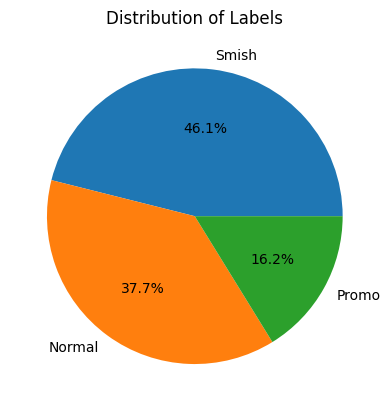

In [24]:
plt.pie(df['label'].value_counts(), labels=['Smish', 'Normal', 'Promo'], autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.show()

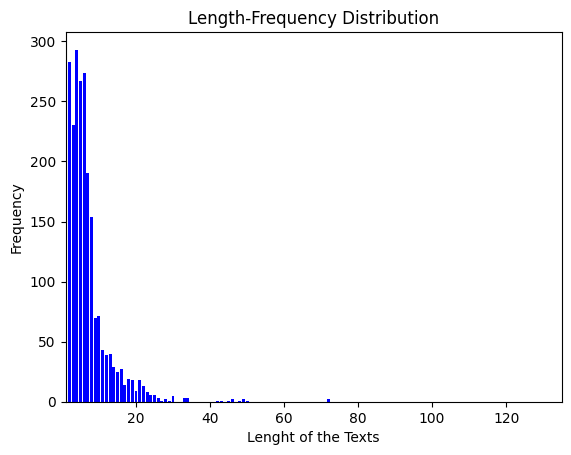

Maximum Length of a Text: 72
Minimum Length of a Text: 1
Average Length of a Text: 7.0


In [25]:
# Calculate the Text of each of the Text
dataset['TextLength'] = dataset.Cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")